<a href="https://colab.research.google.com/drive/1cuJsP-X7pOdvQGRxOBESp9N9HSiSUemQ?usp=sharing">
  <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install transformers
!pip install sentencepiece
#!pip install tensorflow==2.4.0 

     |████████████████████████████████| 2.5MB 25.2MB/s 
     |████████████████████████████████| 901kB 47.4MB/s 
     |████████████████████████████████| 3.3MB 43.8MB/s 
     |████████████████████████████████| 1.2MB 32.6MB/s 


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 27.6MB/s 


In [ ]:
# import module
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from transformers import AutoTokenizer, TFAutoModel

from sklearn.model_selection import train_test_split
AUTO = tf.data.experimental.AUTOTUNE
MAX_LENGTHS = 50

IMPORTING ALL DATASETS

In [ ]:
!gdown --id 1dhdMKM9akp0krL9ObL-kn8K9gSVOwPUp
!gdown --id 1160UzrabHFjB4QjLs6IWU4mZ6fZroGNf
!gdown --id 10FbqBhDzGl_JsFLxFI8SvWmouc0FWQtd

Downloading...
From: https://drive.google.com/uc?id=1dhdMKM9akp0krL9ObL-kn8K9gSVOwPUp
To: /content/AllData.csv
3.25MB [00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1160UzrabHFjB4QjLs6IWU4mZ6fZroGNf
To: /content/All Data Undersampling Max 200.csv
100% 895k/895k [00:00<00:00, 28.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=10FbqBhDzGl_JsFLxFI8SvWmouc0FWQtd
To: /content/Normal.csv
100% 443k/443k [00:00<00:00, 14.1MB/s]


## Yow Read the Dataset

In [ ]:
dfAllData = pd.read_csv("All Data Undersampling Max 200.csv")

In [ ]:
sample = dfAllData.loc[1,"tweet"]
def cleanIt(text):
  
  text = str(text)
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 

  text = re.sub(text_cleaning_hash, " ",text).rstrip()
  text = re.sub(text_cleaning_re, " ",text).rstrip()
  
  return text
cleanIt(sample)

'status dukung gerakan matikan lilin untuk ahok gubernur sebut akun facebok dihack'

In [ ]:
dfNormal = pd.read_csv("Normal.csv")
dfAllData = dfAllData[dfAllData["labels"] != 0]


In [ ]:
dfNormal.loc[:,"labels"] = 0

In [ ]:
dfAllData = pd.concat([dfAllData,dfNormal])

In [ ]:
dfAllData["tweet"] = dfAllData["tweet"].apply(cleanIt)

In [ ]:
dfAllData.loc[dfAllData["labels"] == 3,"labels"]= 2

In [ ]:
dfAllData

,tweet,labels
0,tangkap ahok rakyatbersamafpi indonesia akan h...,2
1,status dukung gerakan matikan lilin untuk ahok...,2
2,aki amien rais bilang prabowo dengan bung karn...,2
3,belajar dari negara tetanga vietnam terbukti k...,2
4,sih cebong sudah kebanyakan makan kotoran joko...,2
...,...,...
1837,"restoran yang terbilang baru , letak nya dekat...",0
1838,"pemandangan nya bagus banget , makanan nya jug...",0
1839,ning the peak tempat e sak juoosss e hawa ini ...,0
1840,"tidak menyesal pakai jasa , pesan ke kantor se...",0


In [ ]:
import plotly.graph_objects as go
counted = dfAllData.groupby('labels')["labels"].aggregate("count")
print(counted)
fig = go.Figure()
fig.add_traces(go.Bar(y = ["Normal","Berita Bohong","OffensiveDanHateSpeech"],x = counted,orientation="h"))
fig.show()

labels
0    1842
1    1842
2    3684
Name: labels, dtype: int64


## TransferLearning Section menggunakan transformer model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Check panjang text Narasi
from collections import Counter
seq_len = [len(text.split()) for text in dfAllData["tweet"] if type(text) != float]
print(Counter(seq_len))

Counter({7: 313, 10: 312, 9: 303, 8: 299, 6: 273, 13: 268, 11: 263, 12: 245, 14: 244, 5: 241, 15: 238, 4: 235, 16: 227, 17: 214, 18: 190, 20: 169, 3: 148, 21: 144, 19: 137, 22: 123, 23: 111, 27: 106, 30: 104, 24: 102, 25: 97, 26: 91, 33: 88, 28: 87, 32: 86, 29: 86, 2: 80, 31: 75, 34: 73, 38: 70, 35: 61, 36: 60, 39: 57, 40: 55, 41: 55, 43: 54, 42: 53, 37: 48, 69: 44, 68: 39, 71: 37, 46: 35, 44: 34, 54: 34, 51: 34, 55: 31, 200: 30, 47: 30, 58: 30, 45: 29, 70: 29, 72: 29, 67: 28, 48: 27, 60: 27, 49: 26, 53: 26, 64: 26, 50: 25, 1: 25, 62: 25, 56: 24, 73: 24, 57: 23, 74: 23, 63: 22, 59: 21, 52: 21, 61: 20, 65: 20, 76: 19, 66: 19, 75: 14, 78: 11, 77: 8, 79: 8, 85: 6, 80: 6, 83: 5, 110: 4, 92: 3, 120: 3, 81: 3, 103: 3, 86: 3, 87: 3, 151: 2, 84: 2, 124: 2, 93: 2, 111: 2, 174: 2, 178: 2, 95: 2, 119: 2, 97: 2, 117: 2, 167: 2, 100: 2, 157: 2, 139: 2, 127: 1, 122: 1, 104: 1, 134: 1, 108: 1, 105: 1, 94: 1, 106: 1, 152: 1, 180: 1, 96: 1, 123: 1, 195: 1, 135: 1, 192: 1, 182: 1, 153: 1, 149: 1, 102: 1

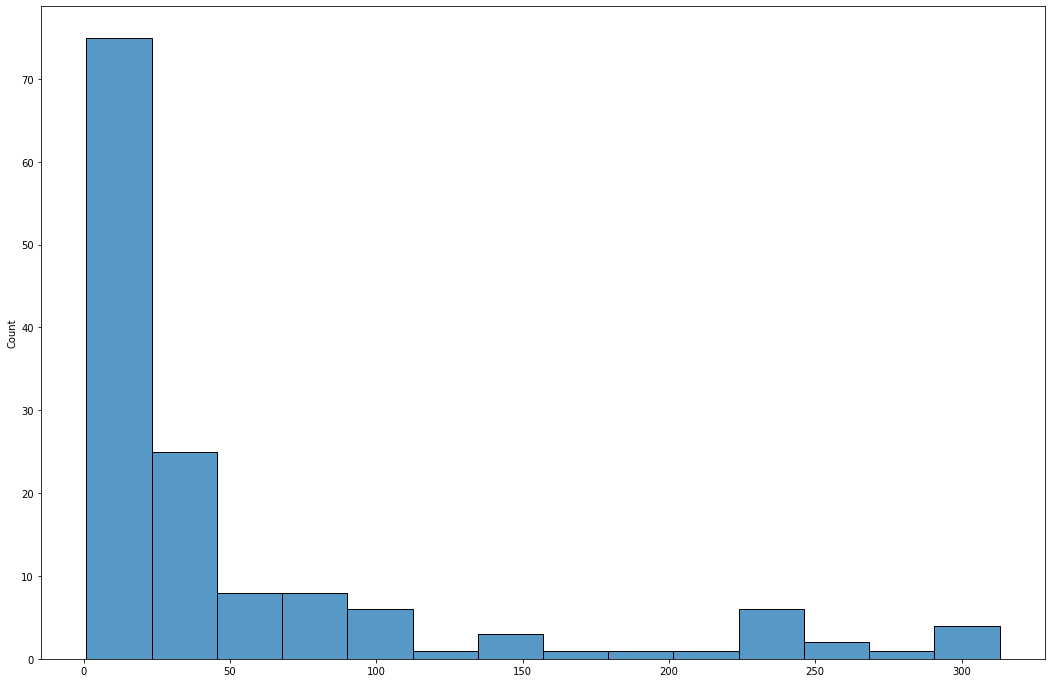

In [ ]:
plt.figure(figsize=(18,12))
sns.histplot(list(dict(Counter(seq_len)).values()))

In [ ]:
x_train,x_val = train_test_split(dfAllData , test_size=0.2, random_state = 10)

In [ ]:
x_train["labels"].value_counts()

2    2974
0    1472
1    1448
Name: labels, dtype: int64

In [ ]:
token_train = {
    "tweet" : tokenizer.batch_encode_plus(
        x_train["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}
token_train

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



{'tweet': {'input_ids': [[2, 436, 18508, 4043, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 92, 90, 1550, 899, 321, 366, 313, 1731, 90, 3407, 904, 2524, 6642, 98, 27346, 51, 34, 735, 219, 1439, 90, 6494, 3407, 904, 2524, 154, 1632, 216, 271, 955, 25725, 34, 1004, 26, 441, 1181, 1731, 3407, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 599, 43, 1585, 308, 1841, 18751, 2496, 1107, 211, 310, 9325, 449, 310, 8680, 30470, 12219, 6362, 1107, 2944, 8680, 2083, 1107, 30470, 515, 724, 1678, 41, 79, 4962, 34, 724, 1305, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 5162, 18272, 30365, 3649, 508, 1585, 7996, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 92, 633, 736, 1095, 43, 989, 1108, 14701, 211, 6379, 98, 1614, 968, 24479, 3731, 3075, 20160, 2173, 30469, 304, 30468, 1369, 731, 2886, 6787, 684, 4962, 1107, 1305,

In [ ]:
token_val = {
    "tweet" : tokenizer.batch_encode_plus(
        x_val["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}
token_val

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



{'tweet': {'input_ids': [[2, 8641, 3132, 877, 916, 664, 1856, 7893, 508, 2911, 6621, 3132, 877, 7249, 1655, 3339, 30370, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 515, 1107, 12398, 30470, 1305, 5080, 6110, 3522, 17188, 2246, 2983, 30457, 2382, 79, 11487, 8214, 668, 7751, 5039, 30470, 968, 9377, 3009, 4595, 30470, 209, 1095, 1233, 2418, 4279, 12000, 1107, 2125, 99, 30470, 1175, 874, 30470, 418, 2983, 30470, 209, 2054, 283, 1622, 245, 751, 12000, 3], [2, 977, 5165, 6013, 982, 171, 233, 5165, 3588, 23366, 32, 41, 15475, 5621, 41, 1124, 900, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 8918, 154, 955, 34, 310, 3080, 26, 300, 30470, 955, 34, 1756, 1522, 2972, 79, 15881, 1990, 92, 407, 955, 34, 20420, 98, 5771, 4385, 30470, 1856, 551, 719, 26, 300, 343, 7670, 8918, 34, 1198, 30470, 427, 282, 1107, 154, 4452, 2236, 30470, 7670, 8918, 34, 1718, 3], [2, 5165, 26, 3351, 32, 34

In [ ]:
train_data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
}

validation_data = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_val["tweet"]["input_ids"])),
}

train_dataWithAttention = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["input_ids"])),
    "tweetMask" : tf.squeeze(tf.convert_to_tensor(token_train["tweet"]["attention_mask"]))
}

validation_dataWithAttention = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_val["tweet"]["input_ids"])),
    "tweetMask" : tf.squeeze(tf.convert_to_tensor(token_val["tweet"]["attention_mask"]))
}

In [ ]:
y_train = tf.convert_to_tensor(x_train["labels"])
y_val = tf.convert_to_tensor(x_val["labels"])

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,3)
y_val = to_categorical(y_val,3)

In [ ]:
datasetTraining = (tf.data.Dataset.from_tensor_slices((train_data,y_train))).batch(64).prefetch(AUTO).repeat()
datasetValidation = (tf.data.Dataset.from_tensor_slices((validation_data,y_val))).batch(64).prefetch(AUTO).cache()

datasetTrainingWithAttention = (tf.data.Dataset.from_tensor_slices((train_data,y_train))).batch(64).prefetch(AUTO).repeat()
datasetValidationWithAttention =(tf.data.Dataset.from_tensor_slices((validation_data,y_val))).batch(64).prefetch(AUTO).cache()

In [ ]:
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ]
def architecture(passedModel):
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ]

  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweet")

  last_hidden_state, pooler_output = passedModel(ids1).to_tuple()
  layers = tf.keras.layers.Flatten()(last_hidden_state)
  layers = tf.keras.layers.Dense(units=500,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  layers = tf.keras.layers.Dense(units=1024,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  fin_layer = tf.keras.layers.Dense(3,activation= tf.nn.softmax)(layers)

  final = tf.keras.Model(inputs=[ids1],outputs=[fin_layer])
  
  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[-5:]:
    layer.trainable = True 
  optimizer = tf.keras.optimizers.Adam(learning_rate=.001,clipnorm=0.001)
  final.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics = METRICS)

  return final

In [ ]:
def indoBertModel():
  return architecture(IndoBert)

In [ ]:
def indoBertModelAttention():
  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweet")
  attention = tf.keras.layers.Input(shape=(MAX_LENGTHS,),dtype=tf.int32,name="tweetMask")

  last_hidden_state, pooler_output = IndoBert(ids1,attention_mask=attention).to_tuple()
  layers = tf.keras.layers.Flatten()(last_hidden_state)
  layers = tf.keras.layers.Dense(units=500,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dropout(0.3)(layers)
  layers = tf.keras.layers.Dense(units=1024,activation=tf.nn.relu)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  fin_layer = tf.keras.layers.Dense(3,activation= tf.nn.softmax)(layers)

  final = tf.keras.Model(inputs=[ids1,attention],outputs=[fin_layer])
  
  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[-5:]:
    layer.trainable = True 
  optimizer = tf.keras.optimizers.Adam(learning_rate=.001,clipnorm=0.001)
  final.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics = METRICS)

  return final
indoBertModelAttentionObj = indoBertModelAttention()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

## Another Models ROBERTA SECTION

In [ ]:
RobertaModelName = "cahya/roberta-base-indonesian-522M"
RobertaModel = TFAutoModel.from_pretrained(RobertaModelName)
RobertaTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
token_train_Roberta = {
    "tweet" : RobertaTokenizer.batch_encode_plus(
        x_train["tweet"].to_list(),
        max_length = MAX_LENGItuTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}

token_val_Roberta = {
    "tweet" : RobertaTokenizer.batch_encode_plus(
        x_val["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}
train_dataRoberta = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"]))
}
validation_dataRoberta = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_val_Roberta["tweet"]["input_ids"]))
}
train_dataRoberta = (tf.data.Dataset.from_tensor_slices((train_dataRoberta,y_train))).batch(64).prefetch(AUTO).repeat()
validation_dataRoberta = (tf.data.Dataset.from_tensor_slices((validation_dataRoberta,y_val))).batch(64).prefetch(AUTO).cache()

def robertaModel():
  model = architecture(RobertaModel)
  return model

Some layers from the model checkpoint at cahya/roberta-base-indonesian-522M were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cahya/roberta-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



## ANOTHER MODEL , BERT

In [ ]:
BertModelName = "cahya/bert-base-indonesian-522M"
BertModel = TFAutoModel.from_pretrained(RobertaModelName)
BertModelTokenizer = AutoTokenizer.from_pretrained(RobertaModelName)
token_train_bert = {
    "tweet" : BertModelTokenizer.batch_encode_plus(
        x_train["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}

token_val_bert = {
    "tweet" : BertModelTokenizer.batch_encode_plus(
        x_val["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}
train_databert = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_Roberta["tweet"]["input_ids"]))
}
validation_databert = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_val_Roberta["tweet"]["input_ids"]))
}
train_databert = (tf.data.Dataset.from_tensor_slices((train_databert,y_train))).batch(64).prefetch(AUTO).repeat()
validation_databert = (tf.data.Dataset.from_tensor_slices((validation_databert,y_val))).batch(64).prefetch(AUTO).cache()

def bertModel():
  model = architecture(BertModel)
  return model

Some layers from the model checkpoint at cahya/roberta-base-indonesian-522M were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cahya/roberta-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning:

The `pad_to_max_length` argu

## ANOTHER MODEL GPT 2

In [ ]:
GPT2Modelname = "cahya/gpt2-small-indonesian-522M"
Gpt2Model = TFAutoModel.from_pretrained(GPT2Modelname)
Gpt2ModelTokenizer = AutoTokenizer.from_pretrained(GPT2Modelname)
Gpt2ModelTokenizer.pad_token = Gpt2ModelTokenizer.eos_token
token_train_GPT2 = {
    "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
        x_train["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        
        truncation = True
    ),
}

token_val_GPT2 = {
    "tweet" : Gpt2ModelTokenizer.batch_encode_plus(
        x_val["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}
train_dataGPT2 = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_GPT2["tweet"]["input_ids"]))
}
validation_dataGPT2 = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_val_GPT2["tweet"]["input_ids"]))
}
train_dataGPT2 = (tf.data.Dataset.from_tensor_slices((train_dataGPT2,y_train))).batch(64).prefetch(AUTO).repeat()
validation_dataGPT2 = (tf.data.Dataset.from_tensor_slices((validation_dataGPT2,y_val))).batch(64).prefetch(AUTO).cache()

def GPT2Model():
  return architecture(Gpt2Model)


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



## ANOTHER MODEL  XLMROBERTA

In [ ]:
XLMRobertaName = "jplu/tf-xlm-roberta-base"
XLMRobertaMultiLingualModel = TFAutoModel.from_pretrained(XLMRobertaName)
XLMRobertaMultiLingualTokenizer = AutoTokenizer.from_pretrained(XLMRobertaName)

token_train_XLMRoberta = {
    "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
        x_train["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}

token_val_XLMRoberta = {
    "tweet" : XLMRobertaMultiLingualTokenizer.batch_encode_plus(
        x_val["tweet"].to_list(),
        max_length = MAX_LENGTHS,
        pad_to_max_length = True,
        truncation = True
    ),
}
train_dataXLMRoberta = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_train_XLMRoberta["tweet"]["input_ids"]))
}
validation_XLMRoberta = {
    "tweet" : tf.squeeze(tf.convert_to_tensor(token_val_XLMRoberta["tweet"]["input_ids"]))
}
train_dataXLMRoberta = (tf.data.Dataset.from_tensor_slices((train_dataXLMRoberta,y_train))).batch(64).prefetch(AUTO).repeat()
validation_dataXLMRoberta = (tf.data.Dataset.from_tensor_slices((validation_XLMRoberta,y_val))).batch(64).prefetch(AUTO).cache()

def XlmRoberta():
  return architecture(XLMRobertaMultiLingualModel)


Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
def initModel():
  return bertModel(),indoBertModel(),robertaModel(),XlmRoberta(),GPT2Model()
bertmodelObj,indobertModelObj,robertaModelObj,xlmRobertaModelObj,GPT2ModelObj = initModel()


In [ ]:
##LsTM SEction
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 550)
tokenizer.fit_on_texts(dfAllData["tweet"].values)
X = tokenizer.texts_to_sequences(dfAllData["tweet"].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X)
Ylstm = tf.keras.utils.to_categorical(dfAllData["labels"])
x_trainlstm,x_valLstm,y_trainlstm,y_valLstm = train_test_split(X,Ylstm,test_size=0.2,random_state=10)
print(X.shape[1])
def lstmModel():
  input_lstm = tf.keras.layers.Input(shape=(X.shape[1],),dtype = tf.int32,name="tweet")
  layers  = tf.keras.layers.Embedding(550,250 )(input_lstm)
  layers = tf.keras.layers.SpatialDropout1D(0.4)(layers)
  layers = tf.keras.layers.LSTM(190, activation=tf.nn.tanh,dropout = 0.4,recurrent_dropout=0.2,)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  output = tf.keras.layers.Dense(3,activation=tf.nn.softmax)(layers)
  
  model = tf.keras.Model(inputs= [input_lstm], outputs = [output])

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer= tf.keras.optimizers.Adam(0.001),
                metrics = METRICS)
  return model



lstm = lstmModel()


132


In [ ]:
#LSTM With GrRU
def lstmGru():
  input_lstm = tf.keras.layers.Input(shape=(X.shape[1],),dtype = tf.int32,name="tweet")
  layers  = tf.keras.layers.Embedding(550,250 )(input_lstm)
  layers = tf.keras.layers.SpatialDropout1D(0.4)(layers)
  layers = tf.keras.layers.LSTM(190, activation=tf.nn.tanh,dropout = 0.4,recurrent_dropout=0.2)(layers)
  layers = tf.keras.layers.Dense(128,activation=tf.nn.relu)(layers)
  output = tf.keras.layers.Dense(4,activation=tf.nn.softmax)(layers)
  
  model = tf.keras.Model(inputs= [input_lstm], outputs = [output])

  model.compile(loss = tfa.losses.SigmoidFocalCrossEntropy(),optimizer= tf.keras.optimizers.Adam(0.001),
                metrics = METRICS)
  return model


In [ ]:
len(token_train_XLMRoberta["tweet"]["input_ids"])

5894

In [ ]:
step = len(token_train_XLMRoberta["tweet"]["input_ids"]) // 64
def trainBert(EPOCHS,CALLBACKS):
  history = bertmodelObj.fit(train_databert,steps_per_epoch = step, validation_data=validation_databert,epochs=EPOCHS)
  return history

def trainRoberta(EPOCHS,CALLBACKS):
  history = robertaModelObj.fit(train_dataRoberta,steps_per_epoch = step,validation_data=validation_dataRoberta,epochs=EPOCHS)
  return history

def trainXlmRoberta(EPOCHS, CALLBACKS):
  history = xlmRobertaModelObj.fit(train_dataXLMRoberta,steps_per_epoch = step,validation_data = validation_dataXLMRoberta,epochs=EPOCHS)
  return history

def trainGpt2(EPOCHS, CALLBACKS):
  history = GPT2ModelObj.fit(train_dataGPT2,steps_per_epoch = step, validation_data = validation_dataGPT2,epochs = EPOCHS)
  return history

def trainIndoBert(EPOCHS, CALLBACKS):
  history = indobertModelObj.fit(datasetTraining,steps_per_epoch = step, validation_data = datasetValidation, epochs= EPOCHS)
  return history

In [ ]:
bertHistory = trainIndoBert(10,"lol")

Epoch 1/10
92/92 [==============================] - 41s 319ms/step - loss: 0.6122 - tp: 4295.0000 - fp: 1318.0000 - tn: 10458.0000 - fn: 1593.0000 - accuracy: 0.7475 - precision: 0.7652 - recall: 0.7294 - auc: 0.9098 - val_loss: 0.4387 - val_tp: 1163.0000 - val_fp: 136.0000 - val_tn: 2812.0000 - val_fn: 311.0000 - val_accuracy: 0.8446 - val_precision: 0.8953 - val_recall: 0.7890 - val_auc: 0.9566
Epoch 2/10
92/92 [==============================] - 26s 286ms/step - loss: 0.4117 - tp: 4764.0000 - fp: 828.0000 - tn: 10832.0000 - fn: 1066.0000 - accuracy: 0.8338 - precision: 0.8519 - recall: 0.8172 - auc: 0.9554 - val_loss: 0.3644 - val_tp: 1220.0000 - val_fp: 151.0000 - val_tn: 2797.0000 - val_fn: 254.0000 - val_accuracy: 0.8541 - val_precision: 0.8899 - val_recall: 0.8277 - val_auc: 0.9664
Epoch 3/10
92/92 [==============================] - 26s 279ms/step - loss: 0.3762 - tp: 4757.0000 - fp: 665.0000 - tn: 10995.0000 - fn: 1073.0000 - accuracy: 0.8437 - precision: 0.8774 - recall: 0.8160

In [ ]:
print(y_train)
pred =np.argmax(indobertModelObj.predict(datasetTraining,steps=step),axis=1)


[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
y_trainCopy = np.argmax(y_train.copy(),axis=1)
y_trainCopy

array([2, 1, 0, ..., 2, 0, 2])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_trainCopy[:5888],pred)

array([[1382,    5,   83],
       [   0, 1309,  138],
       [   0,   62, 2909]])

In [ ]:
def getDifferTrainingIndoBert():
  differ = []
  for indx,content in enumerate(x_train.loc[:5888,"tweet"].values):
     if (y_trainCopy[indx] != pred[indx]):
       differ.append( (x_train.iloc[indx,0],f"TRUE : {y_trainCopy[indx]}",f"PRED {pred[indx]}" ))
  return differ
pd.DataFrame(getDifferTrainingIndoBert()).to_excel("Klasifikasi yang SalahIndoBert.xlsx",index=False)

In [ ]:
def getDifferTrainingLSTM():
  differ = []
  for indx,content in enumerate(x_trainlstm.loc[:,"tweet"].values):
     if (y_trainlstm[indx] != pred[indx]):
       differ.append( (x_train.x_trainlstm[indx,0],f"TRUE : {y_trainlstm[indx]}",f"PRED {pred[indx]}" ))
  return differ
pd.DataFrame(getDifferTrainingIndoBert()).to_excel("Klasifikasi yang SalahLSTM.xlsx",index=False)

In [ ]:
def plotlah(history,modelName):
  import plotly.graph_objects as go
  fig = go.Figure()
  history.history["epochs"] = list(range(1,10))
  fig.add_trace(go.Scatter(y= history.history["accuracy"],x= history.history["epochs"],mode="lines+markers",name="Training acc"))
  fig.add_trace(go.Scatter(y= history.history["val_accuracy"],x= history.history["epochs"],mode="lines+markers",name="Val acc"))
  fig.update_layout(title=modelName)
  fig.show()

In [ ]:
### NOn Ettention
lstmHistory = lstm.fit(x_trainlstm,y_trainlstm,epochs=10,
                       validation_data=(x_valLstm,y_valLstm))

Epoch 1/10
185/185 [==============================] - 100s 526ms/step - loss: 0.7128 - tp: 3266.0000 - fp: 877.0000 - tn: 10911.0000 - fn: 2628.0000 - accuracy: 0.6917 - precision: 0.7883 - recall: 0.5541 - auc: 0.8614 - val_loss: 0.4903 - val_tp: 1116.0000 - val_fp: 246.0000 - val_tn: 2702.0000 - val_fn: 358.0000 - val_accuracy: 0.7944 - val_precision: 0.8194 - val_recall: 0.7571 - val_auc: 0.9349
Epoch 2/10
185/185 [==============================] - 94s 510ms/step - loss: 0.4619 - tp: 4660.0000 - fp: 910.0000 - tn: 10878.0000 - fn: 1234.0000 - accuracy: 0.8157 - precision: 0.8366 - recall: 0.7906 - auc: 0.9423 - val_loss: 0.4831 - val_tp: 1153.0000 - val_fp: 250.0000 - val_tn: 2698.0000 - val_fn: 321.0000 - val_accuracy: 0.7999 - val_precision: 0.8218 - val_recall: 0.7822 - val_auc: 0.9365
Epoch 3/10
185/185 [==============================] - 93s 505ms/step - loss: 0.4205 - tp: 4824.0000 - fp: 816.0000 - tn: 10972.0000 - fn: 1070.0000 - accuracy: 0.8376 - precision: 0.8553 - recall: 

In [ ]:
plotlah(bertHistory,"IndoBert")

In [ ]:
plotlah(lstmHistory,"LSTM WITHOUT GRU")

In [ ]:
lstm_pred = np.argmax(lstm.predict(x_trainlstm),axis=1)
y_trainlstmRill = np.argmax(y_trainlstm,axis=1)

def confusionGelo(y_true,ypred):
  print(confusion_matrix(y_true,ypred))
print("ConfusionMatrixLSTM")
confusionGelo(y_trainlstmRill,lstm_pred)

ConfusionMatrixLSTM
[[1281  134  100]
 [  54 1292  102]
 [  44   59 2828]]


In [ ]:
print("ConfusionMatrixTransformers")
confusionGelo(np.argmax(y_train[:5888],axis=1),pred)

ConfusionMatrixTransformers
[[1103  222  189]
 [  71 1235  141]
 [  33  102 2792]]
